# Práctica de árboles y ajuste de hiperparámetros

La siguiente práctica consiste en crear un modelo usando árbol de decisión de los datos indios de diabetes encontrados en Kaggle y utilizados en la práctica anterior.

In [1]:
# Importación de bibliotecas de funciones
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import tree
import matplotlib.pyplot as plt
# Etc.

## 1. Carga y preprocesamiento de datos

Haga la carga y las transformaciones necesarias en los datos.  No olvide dividir los datos en entrenamiento y pruebas.  Use una división 85%-15%.

In [2]:
# Load data
pima = pd.read_csv('diabetes.csv')

# División de variables predictoras y objetivo
X = pima.drop("Outcome", axis=1)
y = pima["Outcome"]

# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Visualización inicial
pima.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 2. Regresión lineal

Cree acá una versión de la regresión lineal para los datos indios de diabetes.  Puede ser una versión con LASSO, Ridge o Elastic Net.  Eso sí, haga un modelo para predicción de tipo clasificación en lugar de tipo regresión.  Para ello establezca un umbral, puede ser 0,5.  Todo lo abajo o igual a 0,5 es Outcome = 0, arriba del umbral es Outcome = 1.  Entonces, la variable a predecir es Outcome, no Insulin.  Por último, no borre las filas Insulin = 0.

In [3]:
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import StandardScaler

# Escalamiento
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenamiento modelo RidgeClassifier
ridge_model = RidgeClassifier()
ridge_model.fit(X_train_scaled, y_train)

# Predicciones
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Métricas
print("Accuracy:", accuracy_score(y_test, y_pred_ridge))
print(confusion_matrix(y_test, y_pred_ridge))
print(classification_report(y_test, y_pred_ridge))


Accuracy: 0.7672413793103449
[[65 11]
 [16 24]]
              precision    recall  f1-score   support

           0       0.80      0.86      0.83        76
           1       0.69      0.60      0.64        40

    accuracy                           0.77       116
   macro avg       0.74      0.73      0.73       116
weighted avg       0.76      0.77      0.76       116



## 3. Primer árbol de decisión

### 3.1 Generación del modelo

Cree un árbol de decisión con los datos cargados utilizando `DecisionTreeClassifier`. Use los hiperparámetros por defecto de la clase. Obtenga la exactitud, la matriz de confusión y el informe de clasificación con las funciones `accuracy_score`, `confusion_matrix` y `classification_report` respectivamente.

In [4]:
# Entrenamiento
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Predicciones
y_pred_tree = dt_classifier.predict(X_test)

# Métricas
print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print(confusion_matrix(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))


Accuracy: 0.7068965517241379
[[61 15]
 [19 21]]
              precision    recall  f1-score   support

           0       0.76      0.80      0.78        76
           1       0.58      0.53      0.55        40

    accuracy                           0.71       116
   macro avg       0.67      0.66      0.67       116
weighted avg       0.70      0.71      0.70       116



### 3.2 Visualización del modelo (árbol de decisión)

Visualice el árbol usando un código similar a este:

```python
plt.figure(figsize=(15, 10))
tree.plot_tree(dt_classifier,
               feature_names=X.columns,
               class_names=['No Diabetes', 'Diabetes'],  # Ajuste según las etiquetas
               filled=True,
               rounded=True)
plt.savefig('arbol_decision_diabetes.png')
plt.show()
```



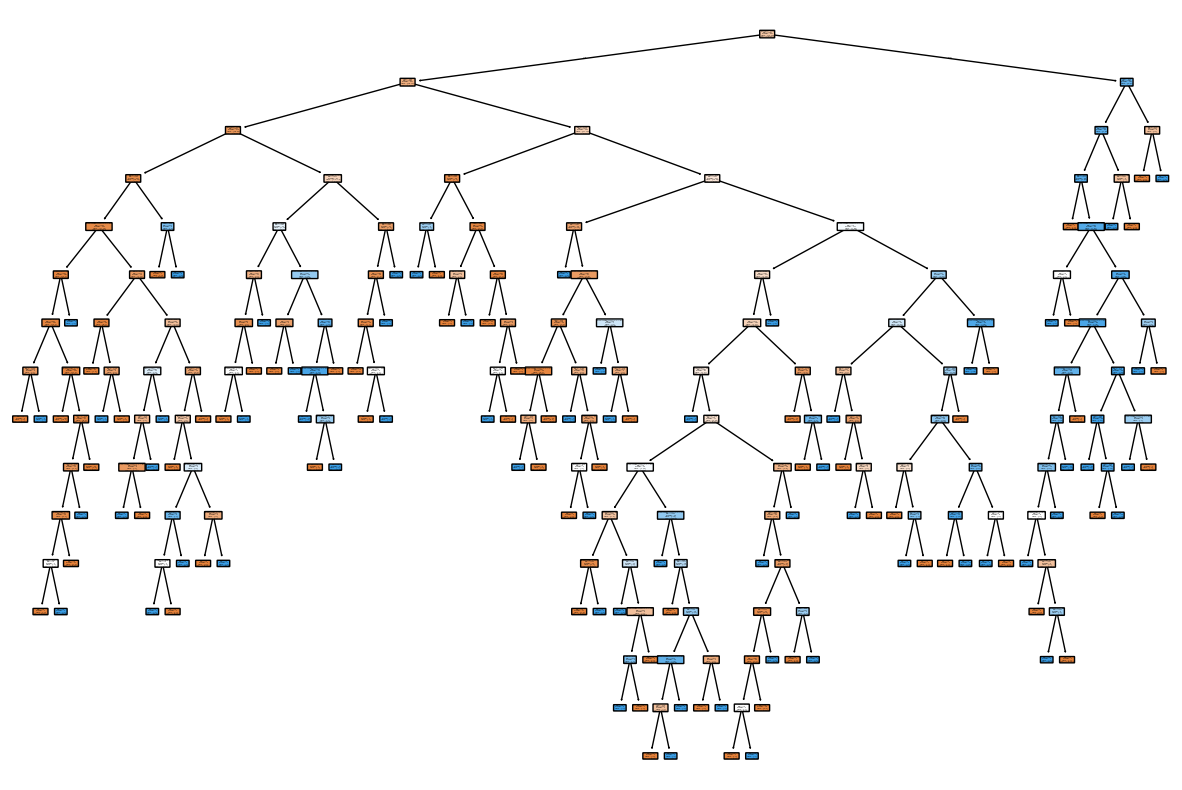

In [5]:
plt.figure(figsize=(15, 10))
tree.plot_tree(dt_classifier,
               feature_names=X.columns,
               class_names=['No Diabetes', 'Diabetes'],
               filled=True,
               rounded=True)
plt.savefig('arbol_decision_diabetes.png')
plt.show()


## 4. Afinamiento de hiperparámetros

Para las siguientes técnicas afine los hiperparámetros del modelo usando los siguientes parámetros de la clase `DecisionTreeClassifier`:


*   max_depth: None, 5, 10, 15, 20
*   min_samples_split: 2, 5, 10
*   min_samples_leaf: 1, 2, 4

### 4.1 *Latin Hypercube Sampling* (LHS)

Utilizando el script en [Latin Hypercube Sampling (LHS) - Integrated Computational Materials Engineering (ICME)](https://www.cavs.msstate.edu/icme/DesignOpt/LHS.php) genere un muestreo en el espacio de búsqueda de los hiperparámetros antes mencionados. Genere entre 35 a 40 muestras. Luego utilice dichas muestras para crear un experimento que permita afinar los hiperparámetros.

In [7]:
!pip install pyDOE2


  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE2: filename=pyDOE2-1.3.0-py3-none-any.whl size=25523 sha256=beed694d68b8bc292d94b4bedb877e0f847edf567acded25f63d74540aca290d
  Stored in directory: /root/.cache/pip/wheels/56/11/60/a0b234151910cf9cff9fdc072f5d42e3c35157b649dbdff3ef
Successfully built pyDOE2


In [8]:
from pyDOE2 import lhs
from sklearn.model_selection import cross_val_score

# Rango de valores
max_depth_vals = [None, 5, 10, 15, 20]
min_samples_split_vals = [2, 5, 10]
min_samples_leaf_vals = [1, 2, 4]

# LHS
lhs_samples = lhs(3, samples=35)
params_list = []

for sample in lhs_samples:
    max_depth = max_depth_vals[int(sample[0] * len(max_depth_vals))]
    min_samples_split = min_samples_split_vals[int(sample[1] * len(min_samples_split_vals))]
    min_samples_leaf = min_samples_leaf_vals[int(sample[2] * len(min_samples_leaf_vals))]
    params_list.append((max_depth, min_samples_split, min_samples_leaf))

# Evaluación de modelos
best_score = 0
best_model = None

for max_depth, min_samples_split, min_samples_leaf in params_list:
    model = DecisionTreeClassifier(max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5).mean()
    if score > best_score:
        best_score = score
        best_model = model

# Entrenar con mejores parámetros
best_model.fit(X_train, y_train)
y_pred_lhs = best_model.predict(X_test)


#### 4.1.1 Métricas

Obtenga la exactitud, la matriz de confusión y el informe de clasificación.

In [9]:
print("Best accuracy (LHS):", accuracy_score(y_test, y_pred_lhs))
print(confusion_matrix(y_test, y_pred_lhs))
print(classification_report(y_test, y_pred_lhs))


Best accuracy (LHS): 0.7844827586206896
[[68  8]
 [17 23]]
              precision    recall  f1-score   support

           0       0.80      0.89      0.84        76
           1       0.74      0.57      0.65        40

    accuracy                           0.78       116
   macro avg       0.77      0.73      0.75       116
weighted avg       0.78      0.78      0.78       116



#### 4.1.2 Visualización del árbol

Visualice el árbol.

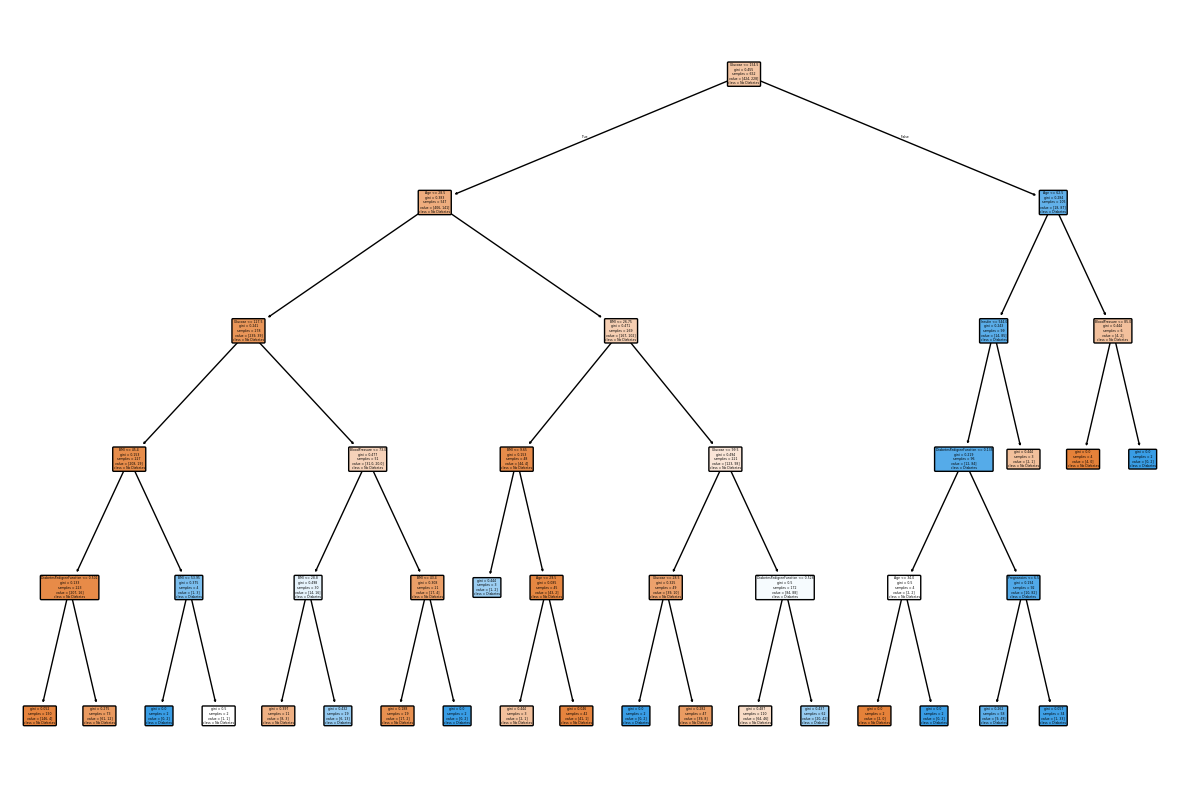

In [10]:
plt.figure(figsize=(15, 10))
tree.plot_tree(best_model,
               feature_names=X.columns,
               class_names=['No Diabetes', 'Diabetes'],
               filled=True,
               rounded=True)
plt.savefig('arbol_LHS.png')
plt.show()


### 4.2 Optuna

Utilizando el marco de trabajo [Optuna](https://optuna.org/) genere ensayos en el espacio de búsqueda de los hiperparámetros antes mencionados. Genere entre 30 a 45 ensayos. Con esas especificaciones genere un experimento que permita afinar los hiperparámetros.

In [12]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 17.4 MB/s eta 0:00:00


In [13]:
import optuna

def objective(trial):
    max_depth = trial.suggest_categorical("max_depth", [None, 5, 10, 15, 20])
    min_samples_split = trial.suggest_categorical("min_samples_split", [2, 5, 10])
    min_samples_leaf = trial.suggest_categorical("min_samples_leaf", [1, 2, 4])

    clf = DecisionTreeClassifier(max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 random_state=42)
    return cross_val_score(clf, X_train, y_train, cv=5).mean()

# Estudio de Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

# Mejor modelo
best_params = study.best_params
optuna_model = DecisionTreeClassifier(**best_params, random_state=42)
optuna_model.fit(X_train, y_train)
y_pred_optuna = optuna_model.predict(X_test)


[I 2025-05-11 02:00:15,068] A new study created in memory with name: no-name-ccc2827a-610b-47e1-8e96-f2c2b87a6bdb
[I 2025-05-11 02:00:15,114] Trial 0 finished with value: 0.6856723429242514 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.6856723429242514.
[I 2025-05-11 02:00:15,158] Trial 1 finished with value: 0.6932941867293012 and parameters: {'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.6932941867293012.
[I 2025-05-11 02:00:15,207] Trial 2 finished with value: 0.6949031121550207 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.6949031121550207.
[I 2025-05-11 02:00:15,253] Trial 3 finished with value: 0.7192953611274222 and parameters: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.7192953611274222.
[I 2025-05-11 02:00:15,310] Trial 4 finished with value: 0.70

#### 4.2.1 Métricas

Obtenga la exactitud, la matriz de confusión y el informe de clasificación.

In [14]:
print("Best accuracy (Optuna):", accuracy_score(y_test, y_pred_optuna))
print(confusion_matrix(y_test, y_pred_optuna))
print(classification_report(y_test, y_pred_optuna))


Best accuracy (Optuna): 0.7844827586206896
[[68  8]
 [17 23]]
              precision    recall  f1-score   support

           0       0.80      0.89      0.84        76
           1       0.74      0.57      0.65        40

    accuracy                           0.78       116
   macro avg       0.77      0.73      0.75       116
weighted avg       0.78      0.78      0.78       116



#### 4.2.2 Visualización del árbol

Visualice el árbol.

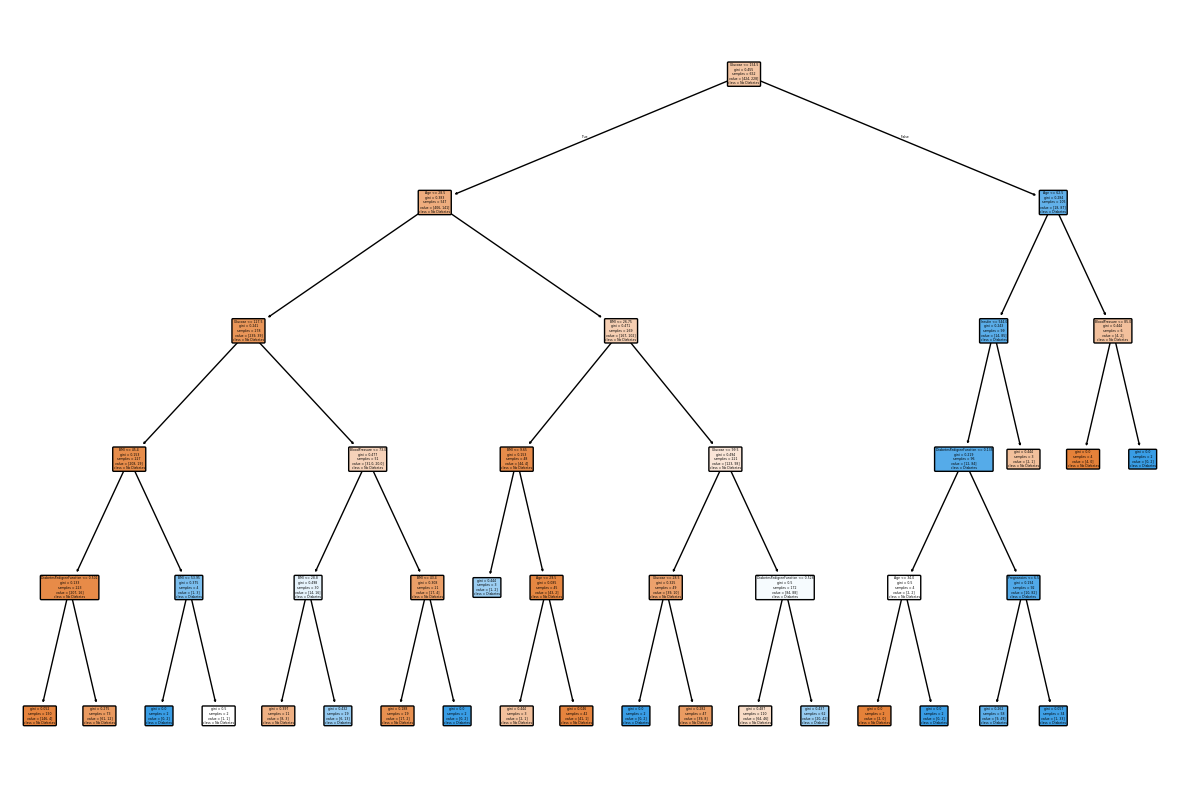

In [15]:
plt.figure(figsize=(15, 10))
tree.plot_tree(optuna_model,
               feature_names=X.columns,
               class_names=['No Diabetes', 'Diabetes'],
               filled=True,
               rounded=True)
plt.savefig('arbol_optuna.png')
plt.show()


### 4.3 GridSearchCV de Scikit-Learn

In [16]:
# 4.3 Grid Search

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import tree

# Definición del espacio de hiperparámetros
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Inicializar el clasificador
dt = DecisionTreeClassifier(random_state=42)

# GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# Ajustar el modelo
grid_search.fit(X_train, y_train)

# mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)


Fitting 5 folds for each of 45 candidates, totalling 225 fits
Mejores hiperparámetros: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}


Utilizando la clase GridSearchCV de Scikit-Learn genere una búsqueda en el espacio de hiperparámetroos antes mencionados.

#### 4.3.1 Métricas

Obtenga la exactitud, la matriz de confusión y el informe de clasificación.

In [17]:
# mejor modelo encontrado
best_dt = grid_search.best_estimator_
y_pred = best_dt.predict(X_test)

# métricas de evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))


Accuracy: 0.7844827586206896

Matriz de confusión:
 [[68  8]
 [17 23]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84        76
           1       0.74      0.57      0.65        40

    accuracy                           0.78       116
   macro avg       0.77      0.73      0.75       116
weighted avg       0.78      0.78      0.78       116



#### 4.3.2 Visualización del árbol

Visualice el árbol.

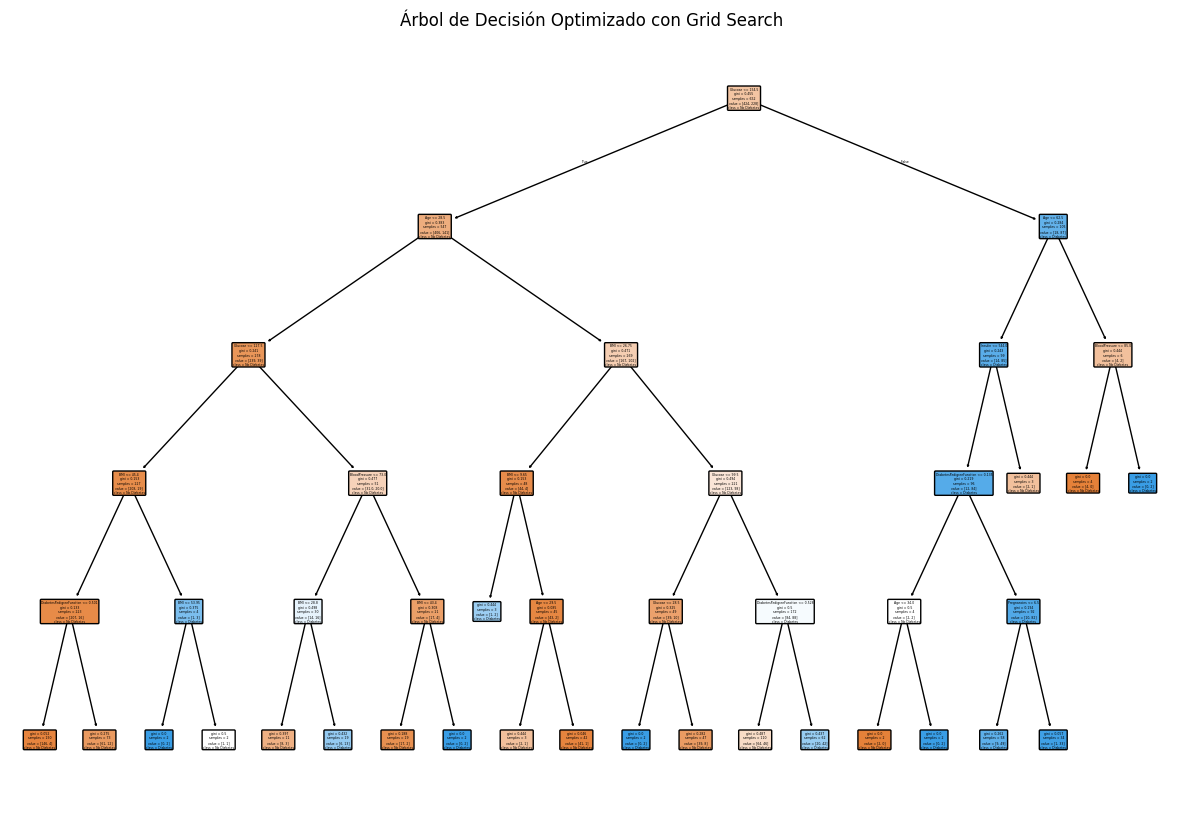

In [18]:
# Visualizar el árbol de decisión resultante
plt.figure(figsize=(15, 10))
tree.plot_tree(best_dt, feature_names=X.columns,
               class_names=['No Diabetes', 'Diabetes'],
               filled=True, rounded=True)
plt.title("Árbol de Decisión Optimizado con Grid Search")
plt.savefig('arbol_decision_grid_search.png')
plt.show()


## 5 Comparación de los modelos

Cree una tabla de métricas del mejor modelo de las técnicas de regresión lineal y de árbol de decisión. Compare, analice y haga una interpretación del resultado..

<ipython-input-20-ecdd04ea8319>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=df, palette='viridis')


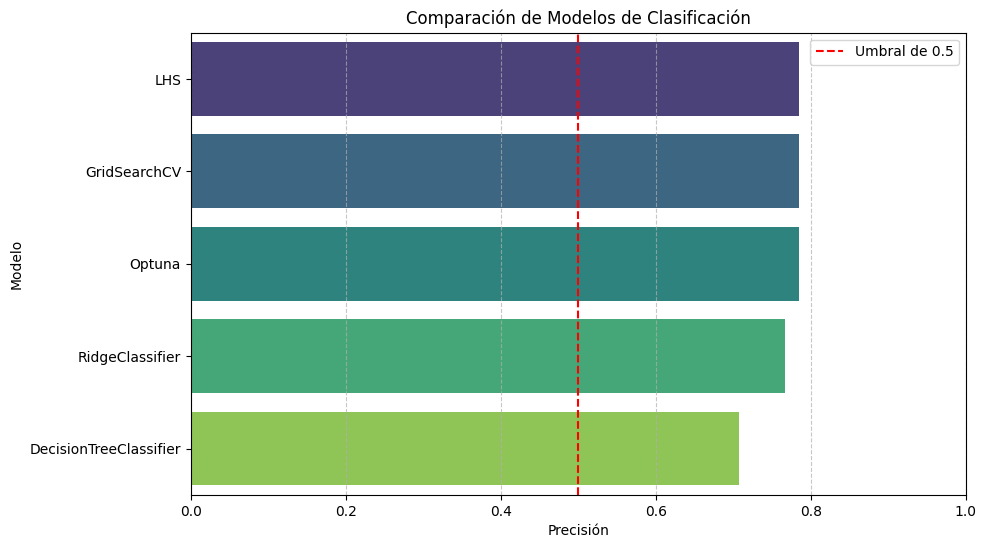

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt


# Definición de los modelos y sus precisiones
models = ['RidgeClassifier', 'DecisionTreeClassifier', 'LHS', 'Optuna', 'GridSearchCV']
accuracies = [accuracy_score(y_test, y_pred_ridge), accuracy_score(y_test, y_pred_tree),
               accuracy_score(y_test, y_pred_lhs), accuracy_score(y_test, y_pred_optuna),
               accuracy_score(y_test, y_pred)]

# Crear un DataFrame para facilitar la visualización
df = pd.DataFrame({'Model': models, 'Accuracy': accuracies})

# Ordenar el DataFrame por precisión
df = df.sort_values(by='Accuracy', ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=df, palette='viridis')
plt.title('Comparación de Modelos de Clasificación')
plt.xlabel('Precisión')
plt.ylabel('Modelo')
plt.xlim(0, 1)  # Limitar el eje x entre 0 y 1
plt.axvline(x=0.5, color='red', linestyle='--', label='Umbral de 0.5')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig('comparacion_modelos.png')
plt.show()


